In [1]:
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path
import pandas as pd

In [2]:
BP_DATA_URL = ("https://www.bp.com/content/dam/bp/business-sites/en/"
               "global/corporate/xlsx/energy-economics/statistical-review/"
               "bp-stats-review-2021-all-data.xlsx")

BP_DATA_FILENAME = Path(BP_DATA_URL.rsplit("/", 1)[1])

In [4]:
if not BP_DATA_FILENAME.exists():
    print(f"Downloading data from: {BP_DATA_URL}")
    urlretrieve(BP_DATA_URL, BP_DATA_FILENAME)
else:
    print(f"Reusing local copy of {BP_DATA_FILENAME}")

In [5]:
POWER_GENERATION_SHEETS = {
    "geo_biomass_other": "Geo Biomass Other - TWh",
    "nuclear": "Nuclear Generation - TWh",
    "hydro": "Hydro Generation - TWh",
    "wind": "Wind Generation - TWh",
    "solar": "Solar Generation - TWh",
    "oil": "Elec Gen from Oil",
    "gas": "Elec Gen from Gas",
    "coal": "Elec Gen from Coal",
}

In [6]:
raw_data_sheets = {
    source: pd.read_excel(BP_DATA_FILENAME, skiprows=2, sheet_name=sheet_name)
    for source, sheet_name in POWER_GENERATION_SHEETS.items()
}

In [10]:
def preprocess_sheet(df):
    df.columns = [str(c).strip() for c in df.columns]
    df = (
        df
        .rename(columns={"Terawatt-hours": "country"})
        .query("not country.isnull()")
        .set_index("country")
        .filter(regex=r"^\d\d\d\d$", axis="columns")
    )
    # print(df)
    df.columns = [int(c) for c in df.columns]
    return df.T

In [11]:
data_sheets = {
    source: preprocess_sheet(df)
    for source, df in raw_data_sheets.items()
}

In [12]:
data_sheets["non_hydro_re"] = (
    data_sheets["solar"]
    + data_sheets["wind"]
    + data_sheets["geo_biomass_other"]
)

In [13]:
data_sheets["low_carbon"] = (
    data_sheets["hydro"]
    + data_sheets["non_hydro_re"]
    + data_sheets["nuclear"]
)

In [14]:
data_sheets["fossil"] = (
    data_sheets["oil"]
    + data_sheets["gas"]
    + data_sheets["coal"]
)

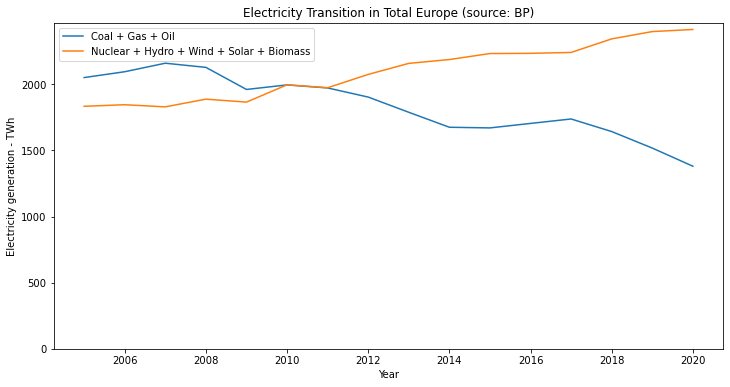

In [16]:
def plot_electricity_transition(country, start_year=2005, group_fossil=True, group_low_carbon=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set(
        xlabel="Year",
        ylabel="Electricity generation - TWh",
        title=f"Electricity Transition in {country} (source: BP)")
    if group_fossil:
        data_sheets["fossil"] .loc[start_year:, country].plot(label="Coal + Gas + Oil")
    else:
        for source in ["coal", "gas", "oil"]:
            data_sheets[source] .loc[start_year:, country].plot(label=source.title())
        
    if group_low_carbon:
        data_sheets["low_carbon"] .loc[start_year:, country].plot(
            label="Nuclear + Hydro + Wind + Solar + Biomass")
    else:
        for source in ["nuclear", "hydro", "wind", "solar", "geo_biomass_other"]:
            data_sheets[source] .loc[start_year:, country].plot(
                label=source.replace("_", " / ").title())
    ax.legend()
    ax.set_ylim(bottom=0)
    
    
plot_electricity_transition("Total Europe", group_fossil=True, group_low_carbon=True)

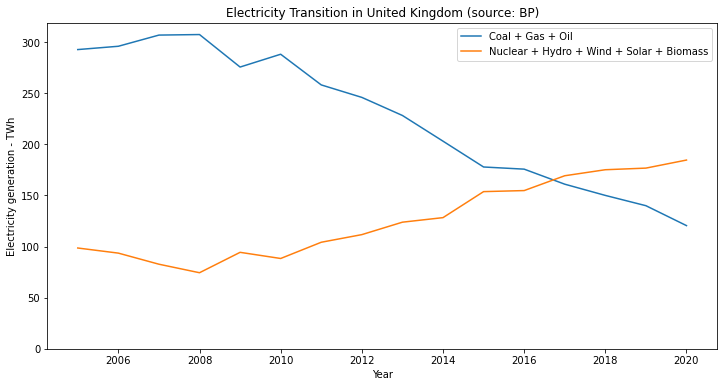

In [17]:
plot_electricity_transition("United Kingdom")

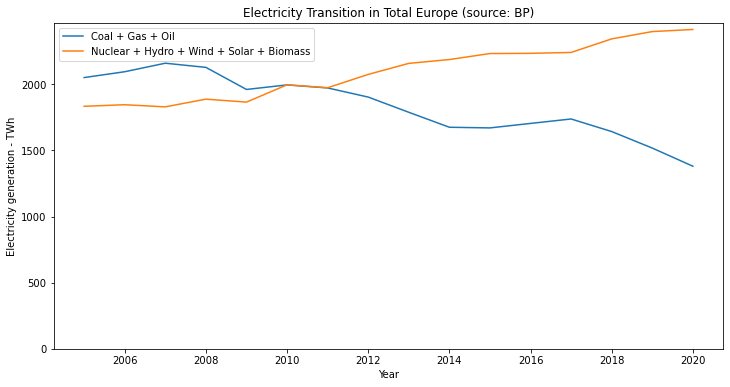

In [18]:
plot_electricity_transition("Total Europe")

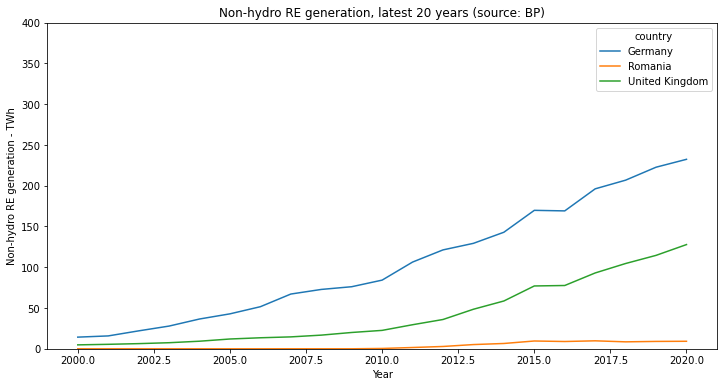

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(
    xlabel="Year",
    ylim=(0, 400),
    ylabel="Non-hydro RE generation - TWh",
    title="Non-hydro RE generation, latest 20 years (source: BP)")
data_sheets["non_hydro_re"].loc[2000:2020, ["Germany", "Romania", "United Kingdom"]].plot(ax=ax);

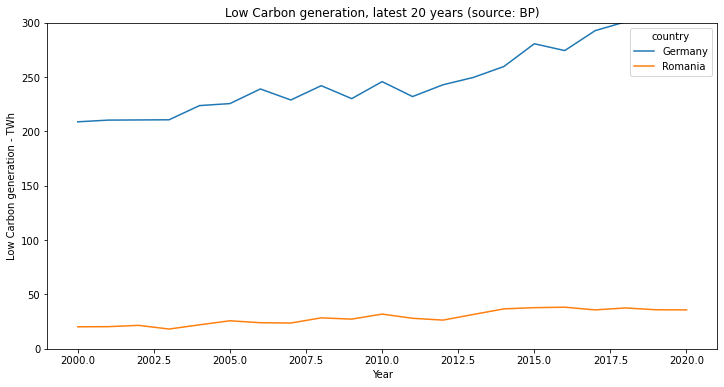

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(
    xlabel="Year",
    ylim=(0, 300),
    ylabel="Low Carbon generation - TWh",
    title="Low Carbon generation, latest 20 years (source: BP)")
data_sheets["low_carbon"].loc[2000:2020, ["Germany", "Romania"]].plot(ax=ax);

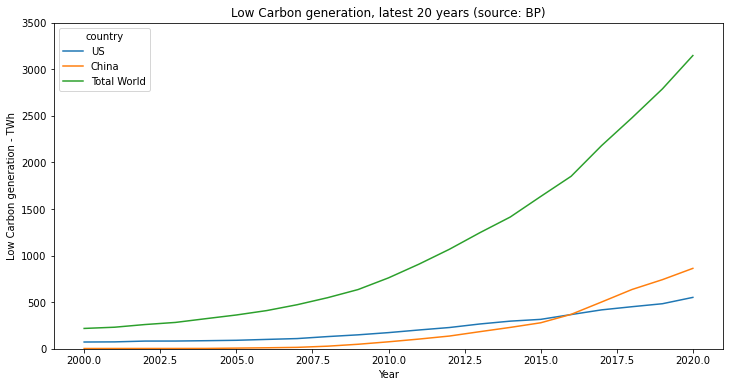

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(
    xlabel="Year",
    ylim=(0, 3500),
    ylabel="Low Carbon generation - TWh",
    title="Low Carbon generation, latest 20 years (source: BP)")
data_sheets["non_hydro_re"].loc[2000:2020, ["US", "China", "Total World"]].plot(ax=ax);